<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Explainable-AI/Grad_CAM_for_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2
import os
from random import shuffle
from tqdm import tqdm
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls

drive  sample_data


In [4]:
!ls drive

MyDrive  Shareddrives


In [3]:
# setting path of directory
G_DIR = "/content/drive/MyDrive/New dataset/glioma/Train"
M_DIR =  "/content/drive/MyDrive/New dataset/meningioma/Train"
P_DIR = "/content/drive/MyDrive/New dataset/pituitary/Train"


# storing all the files from directories PARA_DIR and NORM_DIR to Pimages and Nimages for accessing images directly
Gimages = os.listdir(G_DIR)
Mimages = os.listdir(M_DIR)
Pimages = os.listdir(P_DIR)

Checking sample images

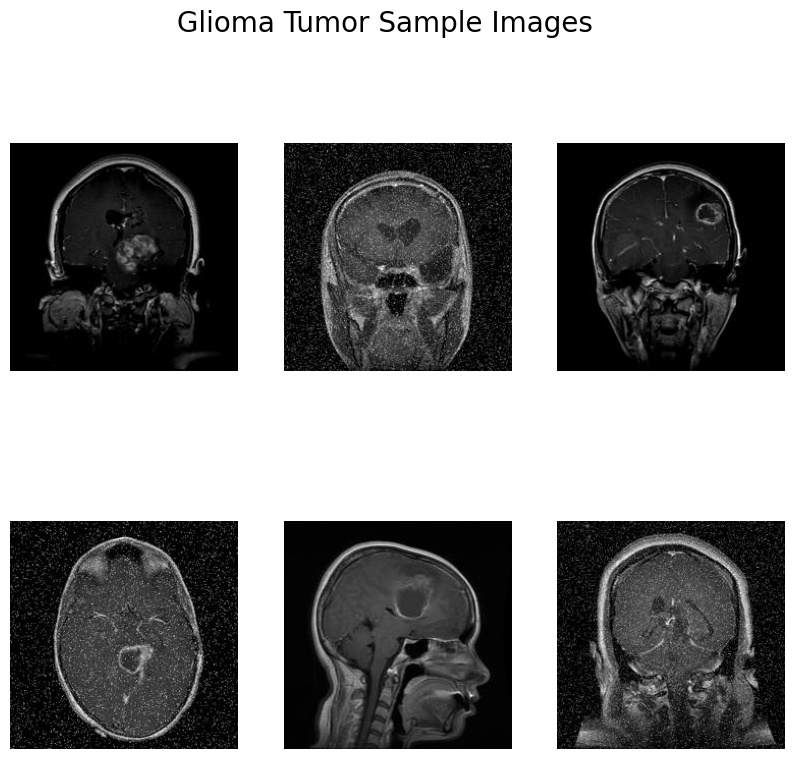

In [10]:
sample_tumor = random.sample(Gimages,6)
f,ax = plt.subplots(2,3,figsize=(10,9))

for i in range(6):
    # Constructing full image path
    img_path = os.path.join(G_DIR, sample_tumor[i])

    # Reading the image as grayscale
    im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Ensuring the image is loaded successfully
    if im is not None:
        ax[i // 3, i % 3].imshow(im, cmap='gray')  # Use cmap='gray' for grayscale images
    else:
        # Displaying a placeholder if image is not found
        ax[i // 3, i % 3].text(0.5, 0.5, 'Image Not Found', ha='center', va='center', fontsize=12)
        ax[i // 3, i % 3].set_facecolor('gray')

    ax[i // 3, i % 3].axis('off')

f.suptitle('Glioma Tumor Sample Images', fontsize=20)
plt.show()


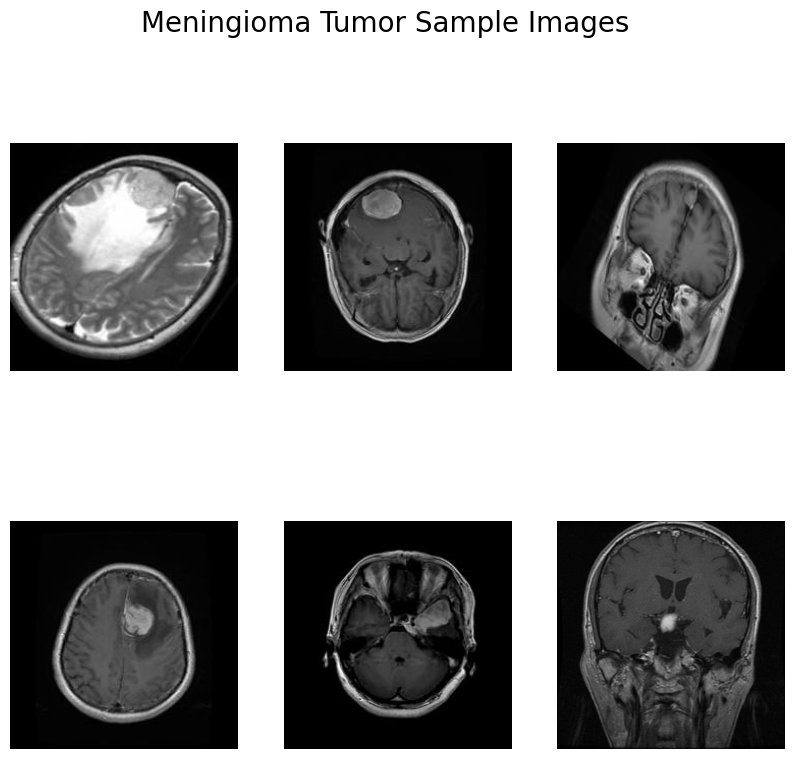

In [12]:
sample_tumor = random.sample(Mimages,6)
f,ax = plt.subplots(2,3,figsize=(10,9))

for i in range(6):
    # Constructing full image path
    img_path = os.path.join(M_DIR, sample_tumor[i])

    # Reading the image as grayscale
    im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Ensuring the image is loaded successfully
    if im is not None:
        ax[i // 3, i % 3].imshow(im, cmap='gray')  # Use cmap='gray' for grayscale images
    else:
        # Displaying a placeholder if image is not found
        ax[i // 3, i % 3].text(0.5, 0.5, 'Image Not Found', ha='center', va='center', fontsize=12)
        ax[i // 3, i % 3].set_facecolor('gray')

    ax[i // 3, i % 3].axis('off')

f.suptitle('Meningioma Tumor Sample Images', fontsize=20)
plt.show()

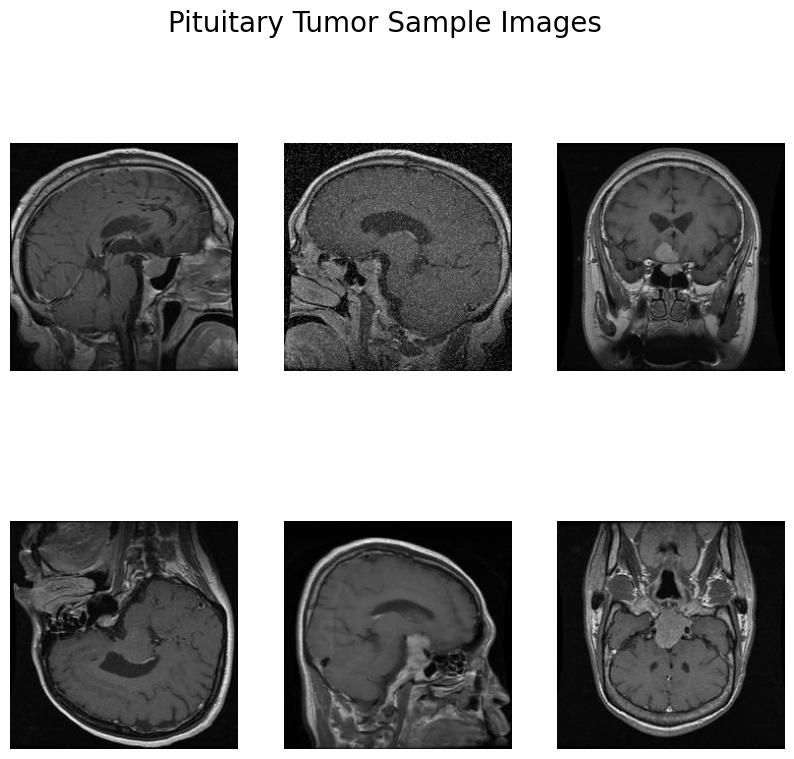

In [13]:
sample_tumor = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(10,9))

for i in range(6):
    # Constructing full image path
    img_path = os.path.join(P_DIR, sample_tumor[i])

    # Reading the image as grayscale
    im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Ensuring the image is loaded successfully
    if im is not None:
        ax[i // 3, i % 3].imshow(im, cmap='gray')  # Use cmap='gray' for grayscale images
    else:
        # Displaying a placeholder if image is not found
        ax[i // 3, i % 3].text(0.5, 0.5, 'Image Not Found', ha='center', va='center', fontsize=12)
        ax[i // 3, i % 3].set_facecolor('gray')

    ax[i // 3, i % 3].axis('off')

f.suptitle('Pituitary Tumor Sample Images', fontsize=20)
plt.show()

Data preparation - loading images and labels

In [4]:
data=[]
labels=[]
Glioma=os.listdir("/content/drive/MyDrive/New dataset/glioma/Train")
for a in Glioma:
    try:
        img_path = os.path.join("/content/drive/MyDrive/New dataset/glioma/Train", a)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if image is not None:
            size_image = cv2.resize(image, (224, 224))  # Resize directly using OpenCV
            data.append(np.array(size_image))
            labels.append(0)
    except Exception as e:
        print(f"Error processing file {a}: {e}")

Meningioma=os.listdir("/content/drive/MyDrive/New dataset/meningioma/Train")
for b in Meningioma:
    try:
        img_path = os.path.join("/content/drive/MyDrive/New dataset/meningioma/Train", b)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if image is not None:
            size_image = cv2.resize(image, (224, 224))  # Resize directly using OpenCV
            data.append(np.array(size_image))
            labels.append(1)
    except Exception as e:
        print(f"Error processing file {b}: {e}")

Pituitary=os.listdir("/content/drive/MyDrive/New dataset/pituitary/Train")
for c in Pituitary:
    try:
        img_path = os.path.join("/content/drive/MyDrive/New dataset/pituitary/Train", c)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if image is not None:
            size_image = cv2.resize(image, (224, 224))  # Resize directly using OpenCV
            data.append(np.array(size_image))
            labels.append(2)
    except Exception as e:
        print(f"Error processing file {c}: {e}")


In [5]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
np.save("/content/drive/My Drive/New dataset/feats_train",feats)
np.save("/content/drive/My Drive/New dataset/labels_train",labels)